<font size="6">*Predictive Modeling of Heart Failure using 11 Predictors*<font size="6">

Cardiovascular diseases account for 31% of global mortality, with heart failure emerging as a prominent cause of premature deaths. The imperative to detect heart failure early is underscored by its life-threatening nature. Early detection not only enhances the quality of life for affected individuals but also holds the potential to mitigate medical expenses and facilitate more effective treatment strategies. Our project centers around the pivotal question: **Can a set of key predictors including age, resting blood pressure, maximum heart rate, and cholesterol levels accurately predict the likelihood of an individual experiencing heart failure?**

This predictive endeavor is motivated by the prospect of early detection significantly improving the efficacy of treatment, thereby reducing mortality rates and contributing to the enhancement of global health.

To address this question, we leverage the "Heart Failure Prediction" dataset sourced from Kaggle https://www.kaggle.com/fedesoriano/heart-failure-prediction). This dataset encompasses a comprehensive array of demographic, clinical, and laboratory data. Features such as Age, Sex, ChestPain type, resting blood pressure, cholesterol levels, and maximum heart rate will be systematically explored and analyzed.

Through an exploration of these predictors, our objective is to construct a predictive model that can discern patterns and relationships, providing insights into the potential of these predictors in determining the likelihood of heart failure

In [78]:
install.packages("gridExtra")
install.packages("kknn")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [79]:
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
options(repr.matrix.mas.rows=5)
# install.packages("gridExtra")
library(gridExtra)
# install.packages("kknn")
library(kknn)
library(readr)
library(dplyr)
library(knitr)

### <font size="6">Preliminary Exploratory Data Analysis<font size="6">
    
**Data Retrieval/wrangling and cleaning:** We used the URL from kaggle to read our data into R and and convert into a tidy format. Fasting blood sugar is excluded from our data table because the values in that column are displayed as 0 in the dataset provided. 


In [80]:
url<-"https://raw.githubusercontent.com/Muskandavee/PROPOSAL-/main/heart.csv?token=GHSAT0AAAAAACIL7C5ONUF7EQO6NRJV2VSKZJ4MAEQ"

In [81]:
#download.file(url, "data/heart.csv")
heart_disease_data<-read_csv(url)|>
    mutate(HeartDisease=as_factor(HeartDisease))|>
    rename(ST_depression=Oldpeak)|>
    mutate(HeartDisease=ifelse(HeartDisease==1, "Yes", "No"))|>
    select(-FastingBS)

heart_disease_slice<-heart_disease_data|>
slice(1:5)
heart_disease_slice

Rows: 918 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope
dbl (7): Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak, HeartDisease

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,Sex,ChestPainType,RestingBP,Cholesterol,RestingECG,MaxHR,ExerciseAngina,ST_depression,ST_Slope,HeartDisease
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
40,M,ATA,140,289,Normal,172,N,0.0,Up,No
49,F,NAP,160,180,Normal,156,N,1.0,Flat,Yes
37,M,ATA,130,283,ST,98,N,0.0,Up,No
48,F,ASY,138,214,Normal,108,Y,1.5,Flat,Yes
54,M,NAP,150,195,Normal,122,N,0.0,Up,No


<font size="4">**Splitting data into training and testing set:**<font size="4">

In [82]:
set.seed(1234)
heart_disease_split <- initial_split(heart_disease_data, prop = 0.75, strata = HeartDisease)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

heart_disease_slice_train<-heart_disease_train |>
slice(1:5)
heart_disease_slice_train

Age,Sex,ChestPainType,RestingBP,Cholesterol,RestingECG,MaxHR,ExerciseAngina,ST_depression,ST_Slope,HeartDisease
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
37,M,ATA,130,283,ST,98,N,0,Up,No
39,M,NAP,120,339,Normal,170,N,0,Up,No
54,M,ATA,110,208,Normal,142,N,0,Up,No
48,F,ATA,120,284,Normal,120,N,0,Up,No
42,F,NAP,115,211,ST,137,N,0,Up,No


<font size="4"> **Exploratory data analysis in tabular formats**<font size="4"> 

We created a summary table that gives us the number of observations in each category for the variable "Sex", grouped by the presence or absence of heart disease. We can see that a higher proportion of males (approx. 64%) have a heart disease compared to women (approx. 27%) , this tells us that age can be a good variable to use in classification. We also created the same count table for ChestPainType and found that maybe ASY type of chest pain could be an indicator of heart disease.
    
We will further confirm whether these variables would be good predictors through data visualisation.


In [83]:
num_missing_rows <- sum(!complete.cases(heart_disease_train))
cat("The number of rows with missing data is", num_missing_rows, "\n")

summary_table_categorical <-  heart_disease_train %>%
  group_by(HeartDisease, Sex) %>%
  summarise(
    Count = n() )
summary_table_categorical
sex_count <- table(heart_disease_train$Sex)
sex_count
summary_table_categorical2 <-  heart_disease_train %>%
  group_by(HeartDisease, ChestPainType) %>%
  summarise(
    Count = n() )
summary_table_categorical2

num_obs <- nrow(heart_disease_train)
heart_disease_train |>
  group_by(HeartDisease) |>
  summarize( count = n(),
    percentage = n() / num_obs * 100)



The number of rows with missing data is 0 


`summarise()` has grouped output by 'HeartDisease'. You can override using the
`.groups` argument.


HeartDisease,Sex,Count
<chr>,<chr>,<int>
No,F,107
No,M,200
Yes,F,39
Yes,M,342



  F   M 
146 542 

`summarise()` has grouped output by 'HeartDisease'. You can override using the
`.groups` argument.


HeartDisease,ChestPainType,Count
<chr>,<chr>,<int>
No,ASY,72
No,ATA,114
No,NAP,100
No,TA,21
Yes,ASY,291
Yes,ATA,17
Yes,NAP,56
Yes,TA,17


HeartDisease,count,percentage
<chr>,<int>,<dbl>
No,307,44.62209
Yes,381,55.37791


Next, we have created a correlation matrix that shows if there is a possible relationship between the numeric variables in our data set. This table helps identify patterns in the distribution of categorical variables across different classes. For instance, it reveals that there is no significant relationship between any of the numeric variables. It also tells us that the scatterplots will show no relationship, which avoids the problem of multicollinearity. Multicollinearity results in reduced interpretability of the model, as it becomes challenging to pin-point the unique contribution of each variable. 

In [84]:
correlation_matrix <- cor(heart_disease_train[, c("Age", "RestingBP", "Cholesterol", "MaxHR")])
correlation_matrix

,Age,RestingBP,Cholesterol,MaxHR
Age,1.00000000,0.25059301,-0.07356863,-0.36087394
RestingBP,0.25059301,1.00000000,0.13246082,-0.09967915
Cholesterol,-0.07356863,0.13246082,1.00000000,0.23033507
MaxHR,-0.36087394,-0.09967915,0.23033507,1.00000000


<font size="4">**DATA VISUALISATION OF TRAINING DATA**<font size="4">
    
We explored the relationship between some of the predictors and heart disease. 


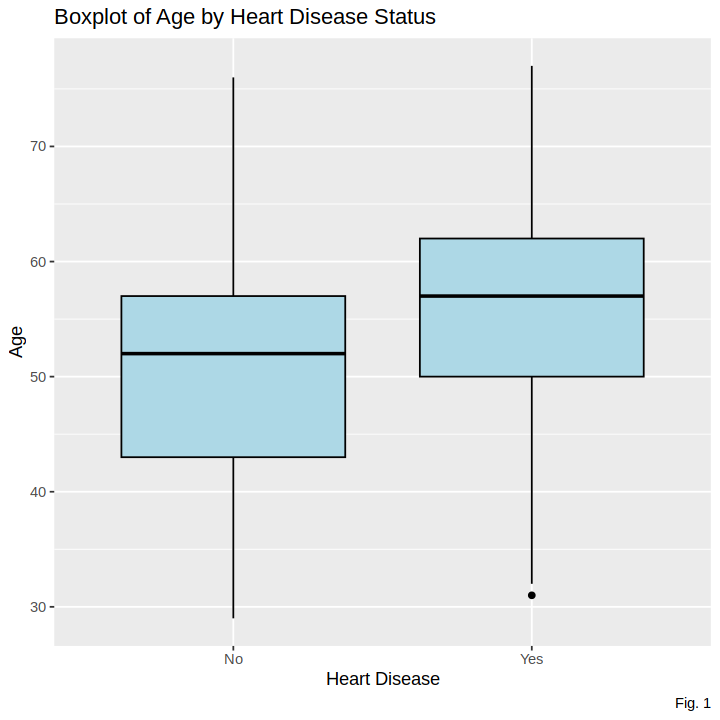

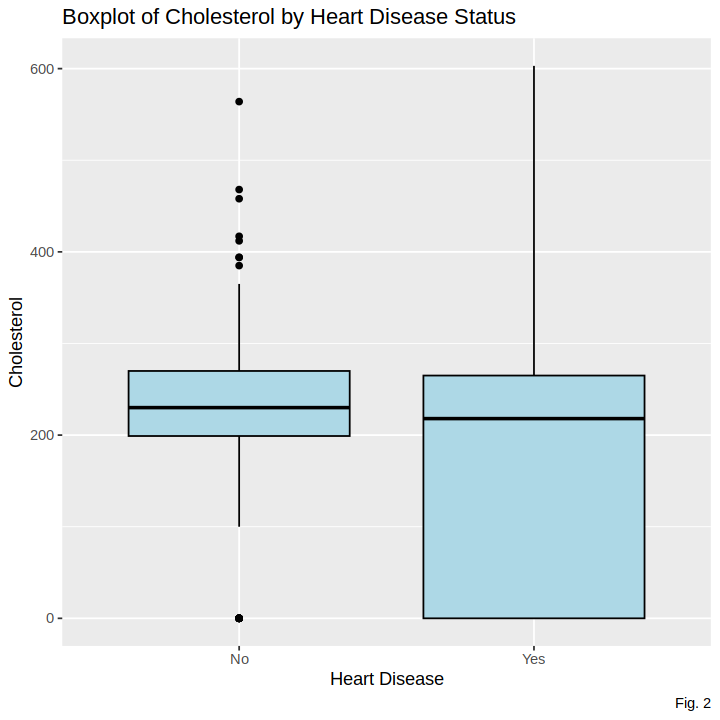

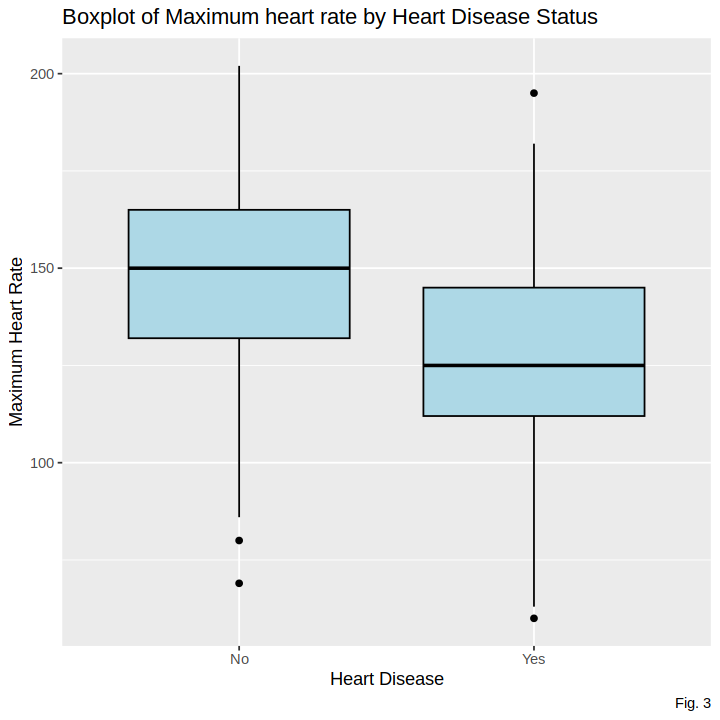

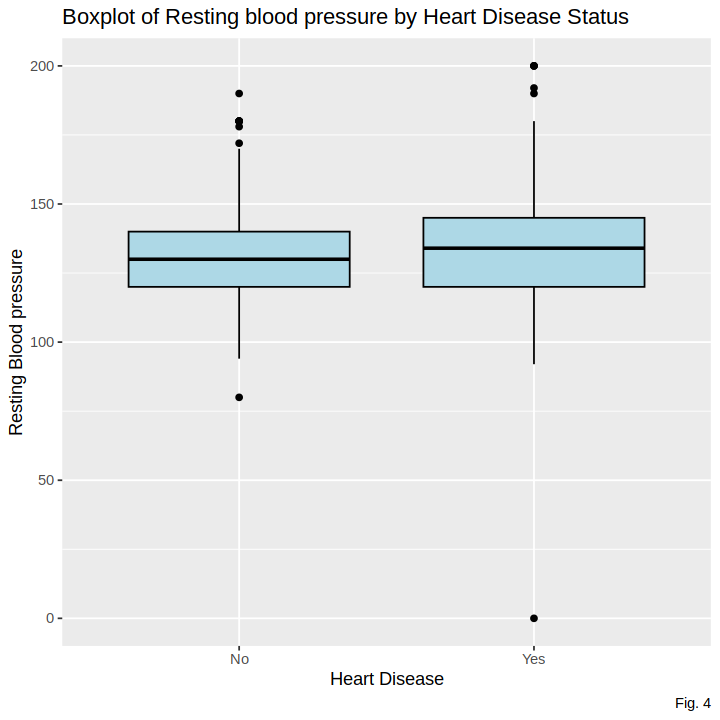

In [85]:
options(repr.plot.width = 6, repr.plot.height = 6)
Age_boxplot <- ggplot(heart_disease_train, aes(x = HeartDisease, y = Age)) +
  geom_boxplot(fill = "lightblue", color = "black") +
  labs(title = "Boxplot of Age by Heart Disease Status",
       x = "Heart Disease",
       y = "Age",
      caption = "Fig. 1")
Age_boxplot 
Cholesterol_boxplot <- ggplot(heart_disease_train, aes(x = HeartDisease, y = Cholesterol)) +
  geom_boxplot(fill = "lightblue", color = "black") +
  labs(title = "Boxplot of Cholesterol by Heart Disease Status",
       x = "Heart Disease",
       y = "Cholesterol",
      caption = "Fig. 2")
Cholesterol_boxplot
MaxHR_boxplot <- ggplot(heart_disease_train, aes(x = HeartDisease, y = MaxHR)) +
  geom_boxplot(fill = "lightblue", color = "black") +
  labs(title = "Boxplot of Maximum heart rate by Heart Disease Status",
       x = "Heart Disease",
       y = "Maximum Heart Rate",
      caption = "Fig. 3")
MaxHR_boxplot
RestingBP_boxplot <- ggplot(heart_disease_train, aes(x = HeartDisease, y = RestingBP)) +
  geom_boxplot(fill = "lightblue", color = "black") +
  labs(title = "Boxplot of Resting blood pressure by Heart Disease Status",
       x = "Heart Disease",
       y = "Resting Blood pressure",
      caption = "Fig. 4")
RestingBP_boxplot




In evaluating potential indicators for heart disease prediction, boxplots revealed distinct median differences for age (Fig. 1) and maximum heart rate (Fig. 2) between individuals with and without heart disease. The clear separation in medians suggests that age and MaxHR could serve as valuable differentiators. We found that heart disease is more prevalent in older ages, with the range of individuals having heart disease being about 50 to 62 years old, while non-heart disease affected individuals ranged from about 46 to 57 years old. Their ability to capture meaningful distinctions makes them good indicators in our k-nearest neighbors (k-NN) analysis, enhancing the predictive capacity of our model. **Hence we have picked Age and Maximum heart rate as our 2 indicator variables in our classification model.**

We have created scatterplots to further explain why we will be using the 2 variables - Max HR and Age.

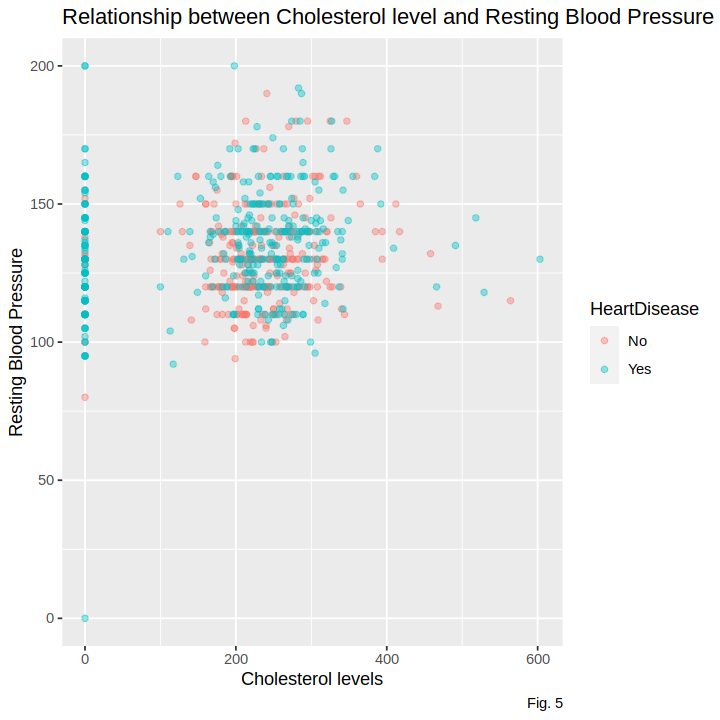

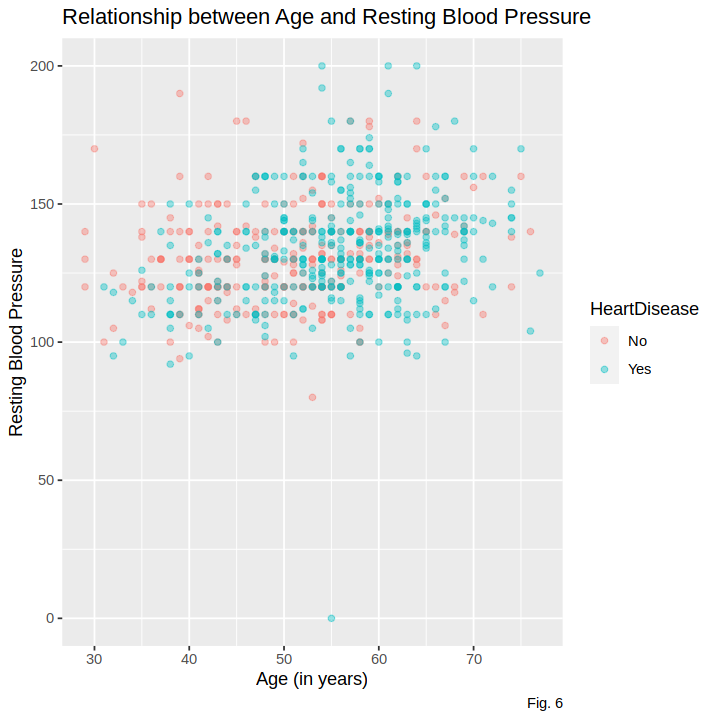

In [86]:
options(repr.plot.width = 6, repr.plot.height = 6)
Cholesterol_bloodpressure_plot<-heart_disease_train|>
ggplot(aes(x=Cholesterol, y=RestingBP))+
geom_point(aes(color=HeartDisease),alpha=0.4)+
labs( x= "Cholesterol levels",
      y ="Resting Blood Pressure",
     title= "Relationship between Cholesterol level and Resting Blood Pressure",
    captions= "Fig. 5")
Cholesterol_bloodpressure_plot

options(repr.plot.width = 6, repr.plot.height = 6)
Age_RestingBP_plot<-heart_disease_train|>
ggplot(aes(x=Age, y=RestingBP))+
geom_point(aes(color=HeartDisease),alpha=0.4)+
labs( x= "Age (in years)",
      y ="Resting Blood Pressure",
     title= "Relationship between Age and Resting Blood Pressure",
    captions= "Fig. 6")
Age_RestingBP_plot

The absence of a systematic trend in the scatterplot indicates that the variables are not strongly correlated, which helps us avoid concerns related to the multicollinearity mentioned above.  In this case, the scatterplot's lack of a pronounced trend suggests that age and cholesterol are relatively independent variables. 

### <font size="5">K-NN Data Analysis<font size="5">
    
We have loaded the data again and split it into a training set for convenience. 

In [22]:
heart_data<-read_csv(url)|>
    mutate(HeartDisease=as_factor(HeartDisease))|>
    rename(ST_depression=Oldpeak)|>

    select(-FastingBS)

heart_disease_slice<-heart_data|>
slice(1:5)
heart_disease_slice

set.seed(1234)
heart_disease_split <- initial_split(heart_data, prop = 0.75, strata = HeartDisease)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

heart_disease_slice_train<-heart_disease_train |>
slice(1:5)
heart_disease_slice_train

Rows: 918 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope
dbl (7): Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak, HeartDisease

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,Sex,ChestPainType,RestingBP,Cholesterol,RestingECG,MaxHR,ExerciseAngina,ST_depression,ST_Slope,HeartDisease
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<fct>
40,M,ATA,140,289,Normal,172,N,0.0,Up,0
49,F,NAP,160,180,Normal,156,N,1.0,Flat,1
37,M,ATA,130,283,ST,98,N,0.0,Up,0
48,F,ASY,138,214,Normal,108,Y,1.5,Flat,1
54,M,NAP,150,195,Normal,122,N,0.0,Up,0


Age,Sex,ChestPainType,RestingBP,Cholesterol,RestingECG,MaxHR,ExerciseAngina,ST_depression,ST_Slope,HeartDisease
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<fct>
37,M,ATA,130,283,ST,98,N,0,Up,0
39,M,NAP,120,339,Normal,170,N,0,Up,0
54,M,ATA,110,208,Normal,142,N,0,Up,0
48,F,ATA,120,284,Normal,120,N,0,Up,0
42,F,NAP,115,211,ST,137,N,0,Up,0


Below, We have set up a 5-fold cross-validation framework using the tidymodels package in R for predicting heart disease. For data preprocessing, we created a recipe that includes MaxHR and Age as predictor variables, scaling and centering all predictors. The model specification involves a k-nearest neighbors (k-NN) approach with rectangular weighting and a tuning parameter for the number of neighbors. We established a grid of odd values from 1 to 100 for the number of neighbors. By constructing a workflow, integrating the preprocessing recipe, k-NN model, and conducted a grid search for hyperparameter tuning using cross-validation. The resulting accuracy metrics for different numbers of neighbors were then extracted for further analysis.

In [23]:
heart_disease_vfold <- vfold_cv(heart_disease_train, v = 5, strata = HeartDisease)

heart_disease_recipe <- recipe(HeartDisease ~MaxHR, Age,
                        data = heart_disease_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

heart_disease_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 2))

heart_disease_results <- workflow() |>
  add_recipe(heart_disease_recipe) |>
  add_model(heart_disease_spec) |>
  tune_grid(resamples = heart_disease_vfold, grid = k_vals) |>
  collect_metrics() 

accuracies <- heart_disease_results |>
  filter(.metric == "accuracy")

accuracies_slice<-accuracies|>
slice(1:5)
accuracies_slice

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5246069,5,0.01826730,Preprocessor1_Model01
3,accuracy,binary,0.5712387,5,0.02976276,Preprocessor1_Model02
5,accuracy,binary,0.5711441,5,0.02006953,Preprocessor1_Model03
7,accuracy,binary,0.6002250,5,0.01614092,Preprocessor1_Model04
9,accuracy,binary,0.6234775,5,0.01348600,Preprocessor1_Model05


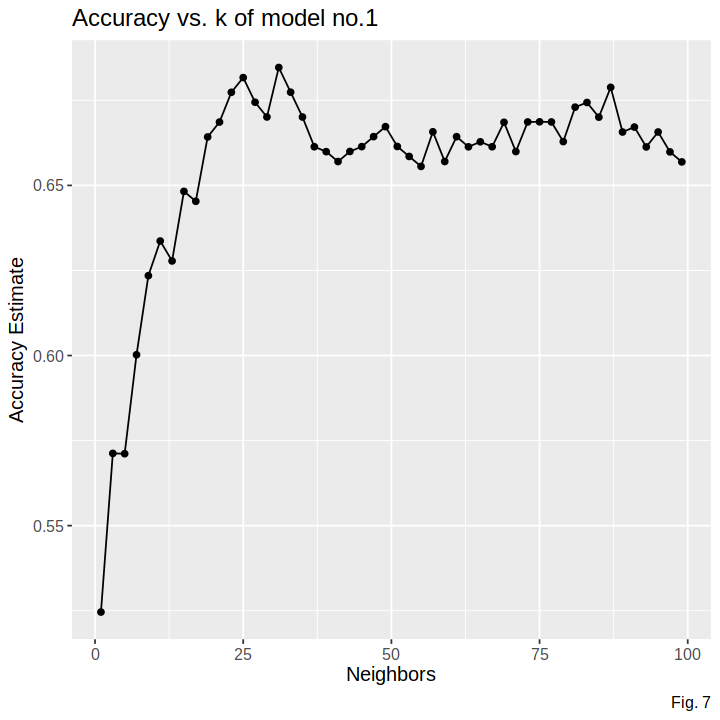

In [88]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", caption= "Fig. 7") + 
  theme(text = element_text(size = 12))+
ggtitle("Accuracy vs. k of model no.1")

accuracy_vs_k

options(repr.plot.width = 6, repr.plot.height = 6)

 This plot provides a clear depiction of how the model's accuracy varies with different numbers of neighbors, aiding in the selection of an optimal k value for the k-NN model in predicting heart disease. We can see that the k value that provides the highest accuracy is 31.

In [25]:
heart_tuned_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = 31) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_tuned_fit <- workflow() |>
  add_recipe(heart_disease_recipe) |>
  add_model(heart_tuned_spec) |>
  fit(data = heart_disease_train)

Then we fine-tuned the k-NN classification model, setting the optimal k value to 31.

In [26]:
heart_disease_prediction<-predict(heart_tuned_fit, heart_disease_test)|>
bind_cols(heart_disease_test)

In [27]:
heart_disease_metrics<-heart_disease_prediction|>
metrics(truth=HeartDisease, estimate=.pred_class)
heart_disease_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6869565
kap,binary,0.3670209


In [28]:
heart_conf_mat<-heart_disease_prediction|>
conf_mat(truth=HeartDisease, estimate=.pred_class)
heart_conf_mat

          Truth
Prediction  0  1
         0 67 36
         1 36 91

The confusion matrix indicates that out of a total of 230 predictions, the model correctly identified 67 instances with no heart disease and 91 instances with heart disease. However, it misclassified 36 instances as having heart disease when they did not, and 36 instances as not having heart disease when they did. 

In [31]:
model_1_recall<-91/(91+36)
recall

function (data, ...) 
{
    UseMethod("recall")
}
<bytecode: 0x55a6f0192918>
<environment: namespace:yardstick>
attr(,"direction")
[1] "maximize"
attr(,"class")
[1] "class_metric" "metric"       "function"

We then wanted to investigate whether the model would work better with one sex than the other, so we repeated the above model building steps with the male and female data separately.

In [32]:
heart_male_data<-heart_data|>
filter(Sex=="M")


heart_male_data_slice<-heart_male_data|>
slice(1:5)
heart_male_data_slice

Age,Sex,ChestPainType,RestingBP,Cholesterol,RestingECG,MaxHR,ExerciseAngina,ST_depression,ST_Slope,HeartDisease
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<fct>
40,M,ATA,140,289,Normal,172,N,0,Up,0
37,M,ATA,130,283,ST,98,N,0,Up,0
54,M,NAP,150,195,Normal,122,N,0,Up,0
39,M,NAP,120,339,Normal,170,N,0,Up,0
54,M,ATA,110,208,Normal,142,N,0,Up,0


In [33]:
set.seed(1234)
heart_male_split <- initial_split(heart_male_data, prop = 0.75, strata = HeartDisease)
heart_male_train <- training(heart_male_split)
heart_male_test <- testing(heart_male_split)

heart_male_slice_train<-heart_male_train |>
slice(1:5)
heart_male_slice_train

Age,Sex,ChestPainType,RestingBP,Cholesterol,RestingECG,MaxHR,ExerciseAngina,ST_depression,ST_Slope,HeartDisease
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<fct>
37,M,ATA,130,283,ST,98,N,0,Up,0
39,M,NAP,120,339,Normal,170,N,0,Up,0
39,M,ATA,120,204,Normal,145,N,0,Up,0
44,M,ATA,120,184,Normal,142,N,1,Flat,0
40,M,NAP,130,215,Normal,138,N,0,Up,0


In [34]:
heart_male_vfold <- vfold_cv(heart_male_train, v = 5, strata = HeartDisease)

heart_male_recipe <- recipe(HeartDisease ~MaxHR, Age,
                        data = heart_male_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

heart_male_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

k_male_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 2))

heart_male_results <- workflow() |>
  add_recipe(heart_male_recipe) |>
  add_model(heart_male_spec) |>
  tune_grid(resamples = heart_male_vfold, grid = k_male_vals) |>
  collect_metrics() 

accuracies_male <- heart_male_results |>
  filter(.metric == "accuracy")


In [35]:
accuracies_male_slice<-accuracies_male|>
slice(1:5)
accuracies_male_slice

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5415053,5,0.01881421,Preprocessor1_Model01
3,accuracy,binary,0.5710160,5,0.02660964,Preprocessor1_Model02
5,accuracy,binary,0.6169725,5,0.02136573,Preprocessor1_Model03
7,accuracy,binary,0.6446823,5,0.02725269,Preprocessor1_Model04
9,accuracy,binary,0.6501869,5,0.02687123,Preprocessor1_Model05


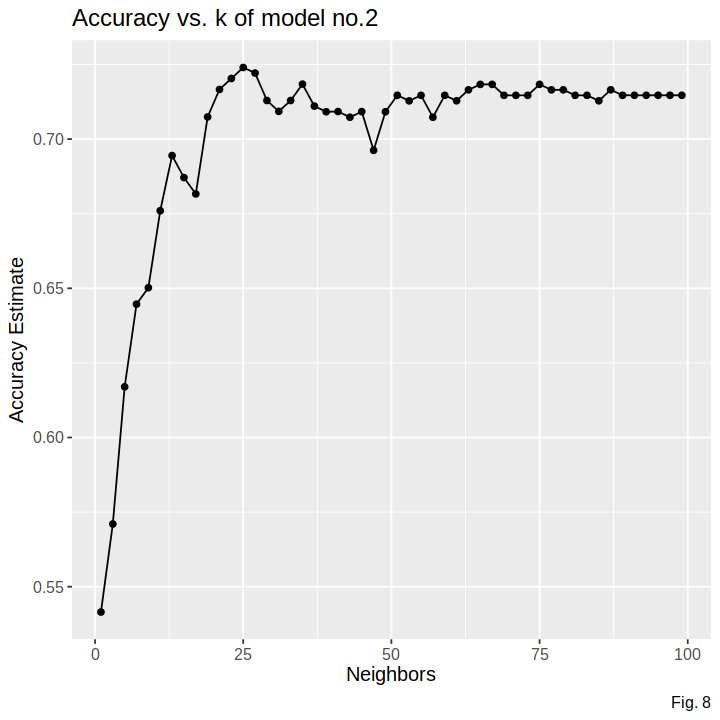

In [89]:
accuracy_vs_k_male <- ggplot(accuracies_male, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", caption= "Fig. 8") + 
  theme(text = element_text(size = 12))+
ggtitle("Accuracy vs. k of model no.2")
accuracy_vs_k_male

options(repr.plot.width = 6, repr.plot.height = 5)

In [37]:
heart_male_tuned_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = 25) |>
  set_engine("kknn") |>
  set_mode("classification")

heart__male_tuned_fit <- workflow() |>
  add_recipe(heart_male_recipe) |>
  add_model(heart_male_tuned_spec) |>
  fit(data = heart_male_train)

In [38]:
heart_male_prediction<-predict(heart__male_tuned_fit, heart_male_test)|>
bind_cols(heart_male_test)

heart_male_prediction_slice<-heart_male_prediction|>
slice(1:5)
heart_male_prediction_slice

.pred_class,Age,Sex,ChestPainType,RestingBP,Cholesterol,RestingECG,MaxHR,ExerciseAngina,ST_depression,ST_Slope,HeartDisease
<fct>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<fct>
0,40,M,ATA,140,289,Normal,172,N,0,Up,0
1,54,M,NAP,150,195,Normal,122,N,0,Up,0
0,54,M,ATA,110,208,Normal,142,N,0,Up,0
1,49,M,ASY,140,234,Normal,140,Y,1,Flat,1
1,60,M,ASY,100,248,Normal,125,N,1,Flat,1


In [39]:
heart_male_metrics<-heart_male_prediction|>
metrics(truth=HeartDisease, estimate=.pred_class)
heart_male_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6813187
kap,binary,0.2883915


The accuracy is slightly better than both combined; however, the kap is lower, which means that the agreement between predictions and actual outcomes is not significantly better than what could occur by chance.

In [40]:
heart_female_data<-heart_data|>
filter(Sex=="F")


heart_female_data_slice<-heart_female_data|>
slice(1:5)
heart_female_data_slice

Age,Sex,ChestPainType,RestingBP,Cholesterol,RestingECG,MaxHR,ExerciseAngina,ST_depression,ST_Slope,HeartDisease
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<fct>
49,F,NAP,160,180,Normal,156,N,1.0,Flat,1
48,F,ASY,138,214,Normal,108,Y,1.5,Flat,1
45,F,ATA,130,237,Normal,170,N,0.0,Up,0
48,F,ATA,120,284,Normal,120,N,0.0,Up,0
37,F,NAP,130,211,Normal,142,N,0.0,Up,0


In [41]:
set.seed(1234)
heart_female_split <- initial_split(heart_female_data, prop = 0.75, strata = HeartDisease)
heart_female_train <- training(heart_female_split)
heart_female_test <- testing(heart_female_split)

heart_female_slice_train<-heart_female_train |>
slice(1:5)
heart_female_slice_train

Age,Sex,ChestPainType,RestingBP,Cholesterol,RestingECG,MaxHR,ExerciseAngina,ST_depression,ST_Slope,HeartDisease
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<fct>
45,F,ATA,130,237,Normal,170,N,0.0,Up,0
48,F,ATA,120,284,Normal,120,N,0.0,Up,0
37,F,NAP,130,211,Normal,142,N,0.0,Up,0
42,F,NAP,115,211,ST,137,N,0.0,Up,0
54,F,ATA,120,273,Normal,150,N,1.5,Flat,0


In [42]:
heart_male_vfold <- vfold_cv(heart_female_train, v = 5, strata = HeartDisease)

heart_female_recipe <- recipe(HeartDisease ~MaxHR, Age,
                        data = heart_female_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

heart_female_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

k_female_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 2))

heart_female_results <- workflow() |>
  add_recipe(heart_female_recipe) |>
  add_model(heart_female_spec) |>
  tune_grid(resamples = heart_male_vfold, grid = k_female_vals) |>
  collect_metrics() 

accuracies_female <- heart_female_results |>
  filter(.metric == "accuracy")


In [43]:
accuracies_female_slice<-accuracies_female|>
slice(1:5)
accuracies_female_slice

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6676190,5,0.01544135,Preprocessor1_Model01
3,accuracy,binary,0.6757143,5,0.04179504,Preprocessor1_Model02
5,accuracy,binary,0.7228571,5,0.02879476,Preprocessor1_Model03
7,accuracy,binary,0.7157143,5,0.01795371,Preprocessor1_Model04
9,accuracy,binary,0.7433333,5,0.01200907,Preprocessor1_Model05


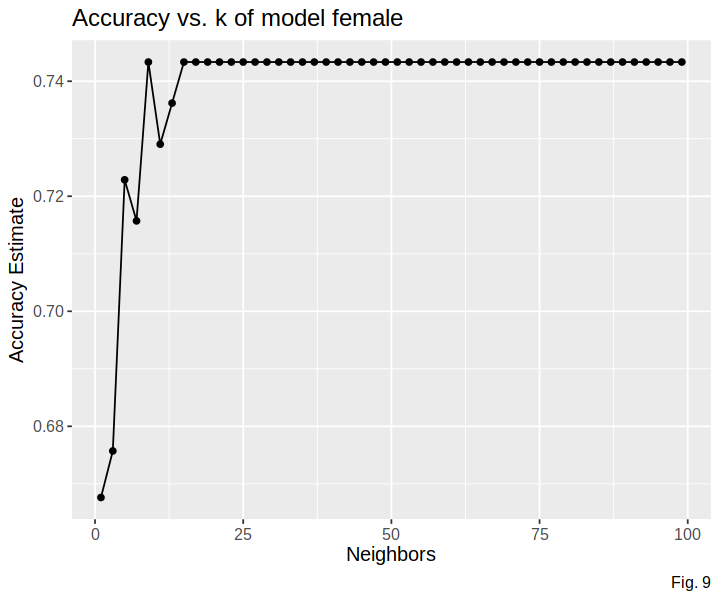

In [90]:
accuracy_vs_k_female <- ggplot(accuracies_female, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate" , caption= "Fig. 9") + 
  theme(text = element_text(size = 12))+
ggtitle("Accuracy vs. k of model female")
accuracy_vs_k_female

options(repr.plot.width = 6, repr.plot.height = 5)

In [45]:
heart_female_tuned_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = 25) |>
  set_engine("kknn") |>
  set_mode("classification")

heart__female_tuned_fit <- workflow() |>
  add_recipe(heart_female_recipe) |>
  add_model(heart_female_tuned_spec) |>
  fit(data = heart_female_train)

In [46]:
heart_female_prediction<-predict(heart__female_tuned_fit, heart_female_test)|>
bind_cols(heart_female_test)

heart_female_prediction_slice<-heart_female_prediction|>
slice(1:5)
heart_female_prediction_slice

.pred_class,Age,Sex,ChestPainType,RestingBP,Cholesterol,RestingECG,MaxHR,ExerciseAngina,ST_depression,ST_Slope,HeartDisease
<fct>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<fct>
0,49,F,NAP,160,180,Normal,156,N,1,Flat,1
0,43,F,TA,100,223,Normal,142,N,0,Up,0
0,48,F,ATA,120,177,ST,148,N,0,Up,0
0,47,F,ASY,120,205,Normal,98,Y,2,Flat,1
0,41,F,ATA,130,245,Normal,150,N,0,Up,0


In [47]:
heart_female_metrics<-heart_female_prediction|>
metrics(truth=HeartDisease, estimate=.pred_class)
heart_female_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7346939
kap,binary,0.0000000


The accuracy for the female model is even higher than the male model, but the kap is 0. This means the agreement between predictions and actual outcomes is basically the same as a random guess. For this reason, I will carry on improving the model using the male data. 

Other than the models shown here, we tested how filtering out different categories affect the accuracy and found out that if we use groups that are at a high risk of having heart diseases, like males with chest pain type of AYP, we would get an accuracy of 95%, but the kap would be 0. This might be due to the imbalance in the data, there are a lot more "yes" than "no" in males with chest pain type of AYP. 

There are variables that play a role in the prediction of heart disease like Resting ECG (Centre (UK)), but we cannot incorporate that into our model because it is a categorical datatype. Therefore, we chose male data with "Normal" ECG level, which does not have significant imbalance as we discovered in our initial proposal through the barplots.

In [48]:
heart_good_data<-heart_male_data|>
filter(RestingECG=="Normal")

heart_good_data_slice<-heart_good_data|>
slice(1:5)
heart_good_data_slice

Age,Sex,ChestPainType,RestingBP,Cholesterol,RestingECG,MaxHR,ExerciseAngina,ST_depression,ST_Slope,HeartDisease
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<fct>
40,M,ATA,140,289,Normal,172,N,0.0,Up,0
54,M,NAP,150,195,Normal,122,N,0.0,Up,0
39,M,NAP,120,339,Normal,170,N,0.0,Up,0
54,M,ATA,110,208,Normal,142,N,0.0,Up,0
37,M,ASY,140,207,Normal,130,Y,1.5,Flat,1


In [49]:
set.seed(1234)
heart_good_split <- initial_split(heart_good_data, prop = 0.75, strata = HeartDisease)
heart_good_train <- training(heart_good_split)
heart_good_test <- testing(heart_good_split)

heart_good_slice_train<-heart_good_train |>
slice(1:5)
heart_good_slice_train

Age,Sex,ChestPainType,RestingBP,Cholesterol,RestingECG,MaxHR,ExerciseAngina,ST_depression,ST_Slope,HeartDisease
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<fct>
54,M,NAP,150,195,Normal,122,N,0,Up,0
39,M,NAP,120,339,Normal,170,N,0,Up,0
54,M,ATA,110,208,Normal,142,N,0,Up,0
44,M,ATA,120,184,Normal,142,N,1,Flat,0
36,M,NAP,130,209,Normal,178,N,0,Up,0


In [50]:
heart_good_vfold <- vfold_cv(heart_good_train, v = 5, strata = HeartDisease)

heart_good_recipe <- recipe(HeartDisease ~MaxHR, Age,
                        data = heart_good_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

heart_good_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

k_good_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 2))

heart_good_results <- workflow() |>
  add_recipe(heart_good_recipe) |>
  add_model(heart_good_spec) |>
  tune_grid(resamples = heart_good_vfold, grid = k_good_vals) |>
  collect_metrics() 


In [51]:

accuracies_good <- heart_good_results |>
  filter(.metric == "accuracy")

accuracies_good_slice<-accuracies_good|>
slice(1:5)
accuracies_good_slice


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5380886,5,0.02082674,Preprocessor1_Model01
3,accuracy,binary,0.6090632,5,0.02940400,Preprocessor1_Model02
5,accuracy,binary,0.6678628,5,0.03280826,Preprocessor1_Model03
7,accuracy,binary,0.6736888,5,0.02278857,Preprocessor1_Model04
9,accuracy,binary,0.6918240,5,0.01997074,Preprocessor1_Model05


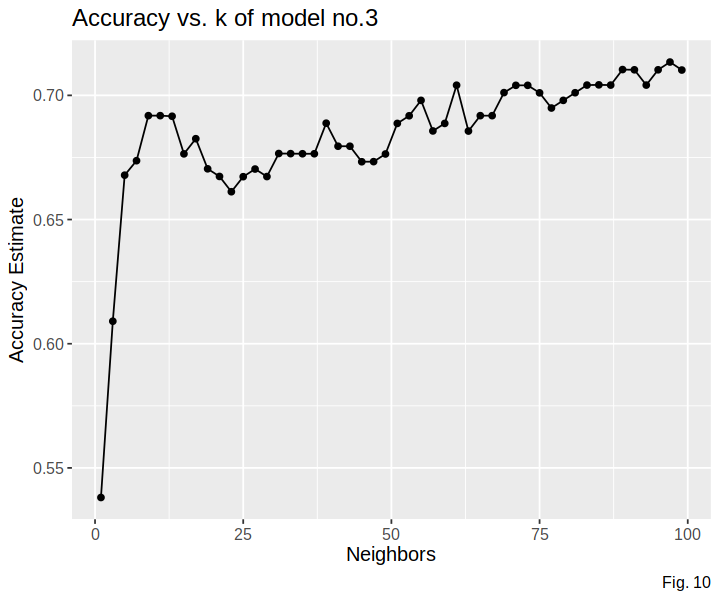

In [91]:
accuracy_vs_k_good <- ggplot(accuracies_good, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate" , caption = "Fig. 10") + 
  theme(text = element_text(size = 12))+
ggtitle("Accuracy vs. k of model no.3")

accuracy_vs_k_good

In [53]:
heart_good_tuned_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = 97) |>
  set_engine("kknn") |>
  set_mode("classification")

heart__good_tuned_fit <- workflow() |>
  add_recipe(heart_good_recipe) |>
  add_model(heart_good_tuned_spec) |>
  fit(data = heart_good_train)

In [54]:
heart_good_prediction<-predict(heart__good_tuned_fit, heart_good_test)|>
bind_cols(heart_good_test)

heart_good_prediction_slice<-heart_good_prediction|>
slice(1:5)
heart_good_prediction_slice

.pred_class,Age,Sex,ChestPainType,RestingBP,Cholesterol,RestingECG,MaxHR,ExerciseAngina,ST_depression,ST_Slope,HeartDisease
<fct>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<fct>
0,40,M,ATA,140,289,Normal,172,N,0.0,Up,0
1,37,M,ASY,140,207,Normal,130,Y,1.5,Flat,1
0,39,M,ATA,120,204,Normal,145,N,0.0,Up,0
0,38,M,ASY,110,196,Normal,166,N,0.0,Flat,1
1,40,M,NAP,130,215,Normal,138,N,0.0,Up,0


In [55]:
heart_good_metrics<-heart_good_prediction|>
metrics(truth=HeartDisease, estimate=.pred_class)
heart_good_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6972477
kap,binary,0.3607606


In [56]:
good_conf_mat<-heart_good_prediction|>
conf_mat(truth=HeartDisease, estimate=.pred_class)
good_conf_mat

          Truth
Prediction  0  1
         0 25 13
         1 20 51

In [57]:
final_model_recall<-51/(51+13)
final_model_recall

[1] 0.796875

From here, we see that both the the accuracy and kap is better than model 1 and 2. The recall is also higher, with ~0.72 in model 1 and ~0.80 in model 4, which is good because we don't want our model to wrongly predict individuals with heart disease as not having the condition.

In [58]:
# create the grid of area/smoothness vals, and arrange in a data frame
are_grid <- seq(min(unscaled_cancer$Area), 
                max(unscaled_cancer$Area), 
                length.out = 100)
smo_grid <- seq(min(unscaled_cancer$Smoothness), 
                max(unscaled_cancer$Smoothness), 
                length.out = 100)
asgrid <- as_tibble(expand.grid(Area = are_grid, 
                                Smoothness = smo_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(knn_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) |> 
  rename(Class = .pred_class)

# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
wkflw_plot <-
  ggplot() +
  geom_point(data = unscaled_cancer, 
             mapping = aes(x = Area, 
                           y = Smoothness, 
                           color = Class), 
             alpha = 0.75) +
  geom_point(data = prediction_table, 
             mapping = aes(x = Area, 
                           y = Smoothness, 
                           color = Class), 
             alpha = 0.02, 
             size = 5) +
  labs(color = "Diagnosis", 
       x = "Area", 
       y = "Smoothness") +
  scale_color_manual(values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 12))

wkflw_plot

ERROR: Error in seq(min(unscaled_cancer$Area), max(unscaled_cancer$Area), length.out = 100): object 'unscaled_cancer' not found


HeartDisease,scaled_Age,scaled_MaxHR
<chr>,<dbl>,<dbl>
No,-1.77725542,-1.541251706
No,-1.56452895,1.318953011
No,0.03091954,0.206651177
No,-0.60725985,-0.667300265
No,-1.24543925,0.008025849


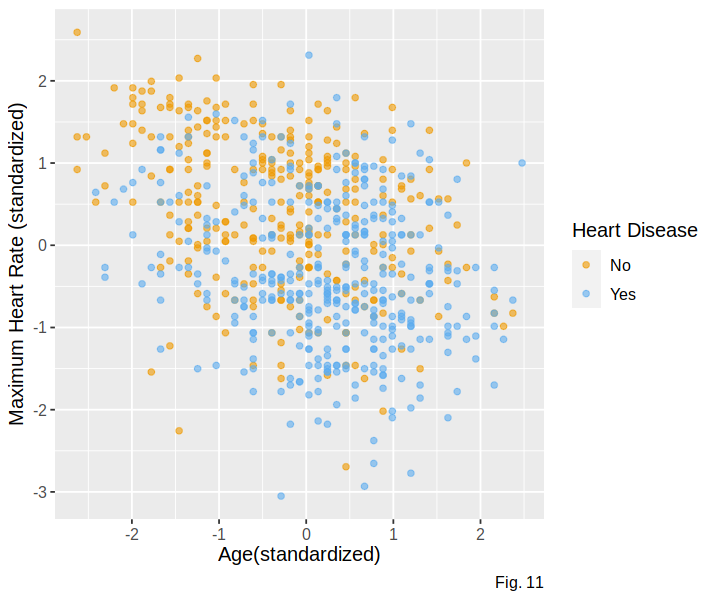

In [93]:
train_data_scaled <- as.data.frame(scale(heart_disease_train[, c("Age", "MaxHR")]))
colnames(train_data_scaled) <- c("scaled_Age", "scaled_MaxHR")
heart_combined <- cbind(heart_disease_train, train_data_scaled)
heart_scaled <- select(heart_combined, HeartDisease , scaled_Age , scaled_MaxHR)

heart_scaled_slice<-heart_scaled|>
    slice(1:5) 
heart_scaled_slice
age_maxHR <- heart_scaled |>
  ggplot(aes(x = scaled_Age, y = scaled_MaxHR, color = HeartDisease)) +
  geom_point(alpha = 0.6) +
  labs(x = "Age(standardized)", 
       y = "Maximum Heart Rate (standardized)",
       color = "Heart Disease" ,
      caption = "Fig. 11" ) +
  scale_color_manual(values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 12))
age_maxHR


<font size="5">Outcomes and Significance<font size="4">
    
Our findings could be impactful because they provide valuable insights into the factors influencing heart disease predictions. For example, the correlation between lower maximum heart rates and increased heart disease prevalence could provide usage for risk assessment based on heart rate monitoring. Additionally, the gender disparity in heart disease prevalence highlights a need for awareness campaigns and targeted health research. Overall, these observations help inform preventative strategies and more personalized healthcare interventions for different demographics and health conditions, which can potentially improve early detection and make a difference in affected patients’ lives. 

**Future potential questions:**
What non-numeric factors could impact the risk of heart disease? (e.g. psychological factors)
Are there specific genetic or lifestyle factors that contribute to the disparity in heart disease prevalence between males and females?
How effective are lifestyle interventions (i.e. diet, exercise) compared to medical risk analyses in decreasing the risk of heart disease?
What are the applications of machine learning algorithms on heart disease predictions? 

**<font size="5">References<font size="5">**
    
        Ali, M. M., Paul, B. K., Ahmed, K., Bui, F. M., Quinn, J. M. W., & Moni, M. A. (2021). Heart disease prediction using supervised machine learning algorithms: Performance Analysis and comparison. Computers in Biology and Medicine, 136, 104672. https://doi.org/10.1016/j.compbiomed.2021.104672  

        Centers for Disease Control and Prevention. (2022, June 3). Target heart rate and estimated maximum heart rate. Centers for Disease Control and Prevention. https://www.cdc.gov/physicalactivity/basics/measuring/heartrate.htm   

